# BEE 4750 Lab 2: Uncertainty and Monte Carlo

**Name**:

**ID**:

> **Due Date**
>
> Wednesday, 9/25/24, 9:00pm

## Setup

The following code should go at the top of most Julia scripts; it will
load the local package environment and install any needed packages. You
will see this often and shouldn’t need to touch it.

In [40]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Users\arisc\OneDrive\Desktop\BEE 4750\lab2-arischor`


In [41]:
using Random # random number generation
using Distributions # probability distributions and interface
using Statistics # basic statistical functions, including mean
using Plots # plotting

## Overview

In this lab, we will use Monte Carlo analysis to analyze a version of
the culmination of every episode of the long-running game show [The
Price Is Right](https://en.wikipedia.org/wiki/The_Price_Is_Right): the
[Showcase](https://en.wikipedia.org/wiki/The_Price_Is_Right#Showcase).

Monte Carlo methods involve the simulation of random numbers from
probability distributions. In an environmental context, we often
propagate these random numbers through some more complicated model and
then compute a resulting statistic which is relevant for assessing
performance or risk, such as an average outcome or a particular
quantile.

You should always start any computing with random numbers by setting a
“seed,” which controls the sequence of numbers which are generated
(since these are not *really* random, just “pseudorandom”). In Julia, we
do this with the `Random.seed!()` function.

In [42]:
Random.seed!(1)

TaskLocalRNG()

It doesn’t matter what seed you set, though different seeds might result
in slightly different values. But setting a seed means every time your
notebook is run, the answer will be the same.

> **Seeds and Reproducing Solutions**
>
> If you don’t re-run your code in the same order or if you re-run the
> same cell repeatedly, you will not get the same solution. If you’re
> working on a specific problem, you might want to re-use
> `Random.seed()` near any block of code you want to re-evaluate
> repeatedly.

### Probability Distributions and Julia

Julia provides a common interface for probability distributions with the
[`Distributions.jl`
package](https://juliastats.org/Distributions.jl/stable/). The basic
workflow for sampling from a distribution is:

1.  Set up the distribution. The specific syntax depends on the
    distribution and what parameters are required, but the general call
    is the similar. For a normal distribution or a uniform distribution,
    the syntax is

    ``` julia
    # you don't have to name this "normal_distribution"
    # μ is the mean and σ is the standard deviation
    normal_distribution = Normal(μ, σ)
    # a is the upper bound and b is the lower bound; these can be set to +Inf or -Inf for an unbounded distribution in one or both directions.
    uniform_distribution = Uniform(a, b)
    ```

    There are lots of both
    [univariate](https://juliastats.org/Distributions.jl/stable/univariate/#Index)
    and
    [multivariate](https://juliastats.org/Distributions.jl/stable/multivariate/)
    distributions, as well as the ability to create your own, but we
    won’t do anything too exotic here.

2.  Draw samples. This uses the `rand()` command (which, when used
    without a distribution, just samples uniformly from the interval
    $[0, 1]$.) For example, to sample from our normal distribution
    above:

    ``` julia
    # draw n samples
    rand(normal_distribution, n)
    ```

Putting this together, let’s say that we wanted to simulate 100
six-sided dice rolls. We could use a [Discrete Uniform
distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.DiscreteUniform).

In [43]:
dice_dist = DiscreteUniform(1, 6) # can generate any integer between 1 and 6
dice_rolls = rand(dice_dist, 100) # simulate rolls

100-element Vector{Int64}:
 1
 3
 5
 4
 6
 2
 5
 5
 5
 2
 ⋮
 3
 6
 5
 5
 6
 3
 6
 6
 6

And then we can plot a histogram of these rolls:

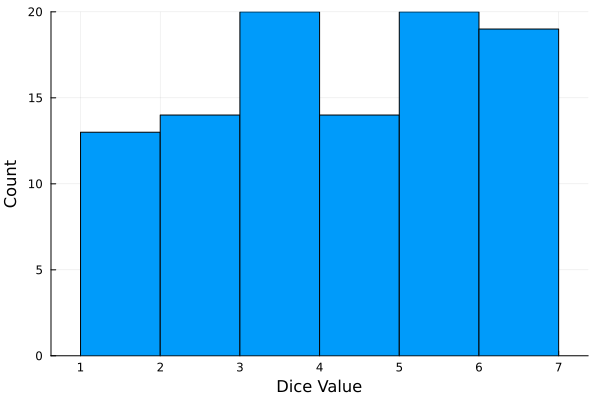

In [44]:
histogram(dice_rolls, legend=:false, bins=6)
ylabel!("Count")
xlabel!("Dice Value")

### Instructions

**Remember to**:

-   Evaluate all of your code cells, in order (using a `Run All`
    command). This will make sure all output is visible and that the
    code cells were evaluated in the correct order.
-   Tag each of the problems when you submit to Gradescope; a 10%
    penalty will be deducted if this is not done.

## Exercise (3 Points)

The Showcase is the final round of every episode of The Price is Right,
matching the two big winners from the episode. Each contestant is shown
a “showcase” of prizes, which are usually some combination of a trip, a
motor vehicle, some furniture, and maybe some other stuff. They then
each have to make a bid on the retail price of the showcase. The rules
are:

-   an overbid is an automatic loss;
-   the contest who gets closest to the retail price wins their
    showcase;
-   if a contestant gets within \$250 of the retail price and is closer
    than their opponent, they win both showcases.

Your goal is to find a wager which maximizes your expected winnings,
which we may as well call utility, based on your assessment of the
probability of your showcase retail price. Make the following
assumptions about your expected winnings if you don’t overbid:

-   If you win both showcases, the value is the double of the single
    showcase value.
-   If you did not win both showcases but bid under the showcase value,
    the probability of being outbid increases linearly as the distance
    between your bid and the value increases (in other words, if you bid
    the exact value, you win with probability 1, and if you bid \$0, you
    win with probability 0).

We’ll assume that the distribution of all showcases offered by the show
is given as truncated normal distribution, which means a normal
distribution which has an upper and/or lower bound. `Distributions.jl`
makes it easy to specify truncations on any distribution, not just
normal distributions. For example, we’ll use the distribution shown in
<a href="#fig-values" class="quarto-xref">Figure 1</a> for the showcase
values (you can just directly use the `showcase_dist` distribution in
your lab code).

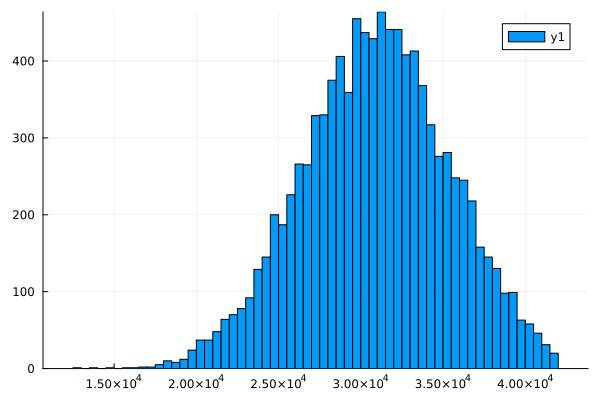

In [45]:
showcase_dist = truncated(Normal(31000, 4500), lower=5000, upper=42000)
showcase_samples = rand(showcase_dist, 10000)
histogram(showcase_samples)

Find your expected winnings if you bid \$35,000. Plot the outcomes of
your Monte Carlo experiment (iterations vs. running estimate). How did
you decide how many samples to use?

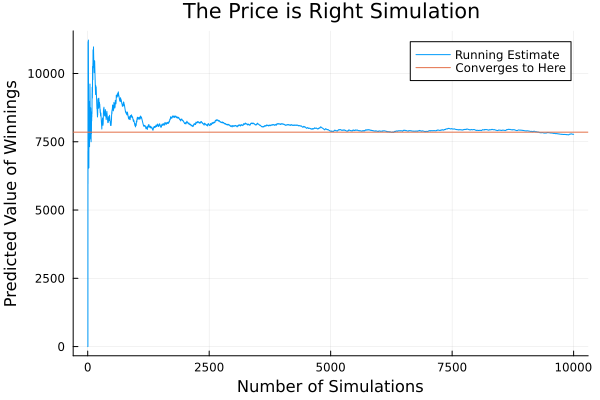

In [46]:
bid = 35000 #dollars
function simulated_earnings(bid, showcase_samples)
    earnings = []
    for i in showcase_samples
        if bid > i
            push!(earnings, 0)
        elseif i-250 <= bid <= i
            push!(earnings, 2*i)
        else bid < i-250
            prob = 1 + (i-bid)/i 
            push!(earnings, prob*i)
        end
    end
    return earnings
end
total_earnings = 0
normalized_earnings = []
earnings = simulated_earnings(bid, showcase_samples)
for k in 1:length(showcase_samples)
    total_earnings = total_earnings + earnings[k]
    push!(normalized_earnings, total_earnings/k)
end
plot(normalized_earnings, label = "Running Estimate")
title!("The Price is Right Simulation")
xlabel!("Number of Simulations")
ylabel!("Predicted Value of Winnings")
hline!([7850], label = "Converges to Here")

# Writeup
**Find your Expected Winnings if you bid $35,000.**

Your expected winnings are $7850. 

In order to calculate expected winnings, I used a Monte Carlo experiment. To do this, I first took a random sampling of 10,000 values from the normalized distribution given to us for possible correct answers in the price is right and stored it in an array. Then, I wrote a function that iterates through every entry in the array and compares it to our inputted bid of $35,000. I then stored the amount of money that the contestant would receive in that round as the corresponding value in the earnings array. If the bid was above the price, I stored zero, and if the bid was within $250 of the price, I stored two times the value of the price. However, if the bid was more than $250 below the price, I had to use the probability of the contestant winning and multiply that by the price of the object. This essentially represents that if the price was the same and the contestant I care about bid $35,000 every time, then we are finding what the average winnings will be after a lot of repititions of the same trial, where the opponents bids are changing causing the outcome to be different. We were given that the probability is a linear function of the distance between the bid and the correct answer, which gives us $probability of win = \frac{price - bid}{price}$. Since we then multiply by the actual price to get the winnings, we get $winnings = price - bid$. After iterating through the entire array of random variables, the function outputs the array of earnings for each round. Then, to find what value the winnings converge to, we have to take the average of all of the outcomes for each trial. To do this, I iterated through the output of the function, taking the mean value of all of the outcomes of the trials so far and storing that in a new array. Finally, I plotted this output of means and saw that they converge to approximately $7850.

**How did you decide how many samples to use?**

I chose to use 10,000 samples through trial and error. I started with 100 trials and then kept increasing the number until I decided that the outcomes appeared to converge to a specific value. I found that, while for slightly lower values the outcomes did still converge a little bit, we truly see the values stay on this line at $7850 for long enough that I feel comfortable saying it is truly stable. It was mostly just by eye, not a mathematical method, but there are likely multiple ways to decide how many trials to use based on the priorities of the person creating the model.

## References

Put any consulted sources here, including classmates you worked with/who
helped you.

Discussed with Jiaming Yuan and Grace Raab in class.

Got a lot of help from Gabriella Ackermann Logan as well.